## Question 1: Data Preprocessing (Medium)

In [ ]:
# Importing the libraries
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import struct
import os

In [ ]:
# Function to read MNIST idx files
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

# Load the MNIST dataset
train_images = read_idx('dataset/train-images.idx3-ubyte')
train_labels = read_idx('dataset/train-labels.idx1-ubyte')
test_images = read_idx('dataset/t10k-images.idx3-ubyte')
test_labels = read_idx('dataset/t10k-labels.idx1-ubyte')

# Normalize pixel values
X_train = train_images.astype('float32') / 255.0
X_test = test_images.astype('float32') / 255.0

# Keep labels as 1D arrays (no one-hot encoding)
y_train = train_labels
y_test = test_labels

X_train, X_val, y_train, y_val = train_test_split(
    X_train, 
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train  # Ensure balanced split
)

# Save processed data
np.save('data/train/X_train.npy', X_train)
np.save('data/train/y_train.npy', y_train)
np.save('data/test/X_test.npy', X_test)
np.save('data/test/y_test.npy', y_test)
np.save('data/test/X_val.npy', X_val)
np.save('data/test/y_val.npy', y_val)

print("Data saved successfully!")
print(f"Training set shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")

## Question 2: Classification (Hard)

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

# Load the preprocessed data
X_train = np.load('data/train/X_train.npy')
y_train = np.load('data/train/y_train.npy')
X_test = np.load('data/test/X_test.npy')
y_test = np.load('data/test/y_test.npy')
X_val = np.load('data/test/X_val.npy')
y_val = np.load('data/test/y_val.npy')

# Reshape the data for logistic regression
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
X_val_reshaped = X_val.reshape(X_val.shape[0], -1)

In [ ]:
# Initial model with default parameters
model = LogisticRegression(multi_class='multinomial', max_iter=1000)
model.fit(X_train_reshaped, y_train)

# Make predictions
y_pred = model.predict(X_test_reshaped)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Define parameter grid
param_grid = {
    'C': [0.1, 1.0],  # Reduced values
    'solver': ['lbfgs', 'saga'],  # Removed 'sag' as it's similar to 'saga'
    'multi_class': ['multinomial']
}

# Perform grid search
grid_search = GridSearchCV(
    LogisticRegression(max_iter=10),
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2  # Add verbose output
)

print("\nStarting Grid Search...")
grid_search.fit(X_train_reshaped, y_train)

# Print best parameters and score
print("\nGrid Search Results:")
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_reshaped)
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Best model accuracy on test set: {accuracy_best:.4f}")

# Print improvement
print(f"\nAccuracy improvement: {(accuracy_best - accuracy)*100:.2f}%")

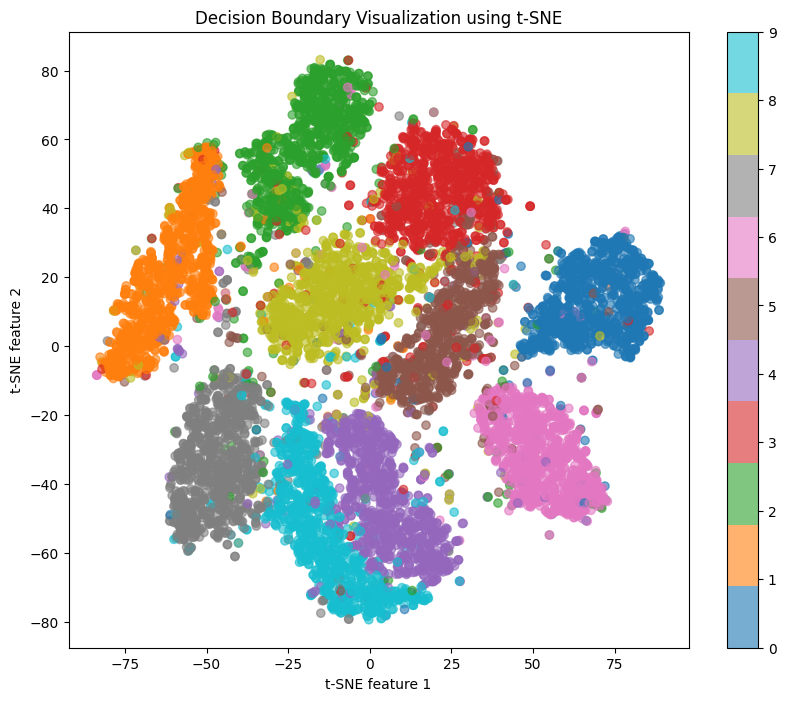

In [5]:
from sklearn.manifold import TSNE

# Apply t-SNE to reduce dimensions to 2D
tsne = TSNE(n_components=2, random_state=42)
X_test_2d = tsne.fit_transform(X_test_reshaped)

# Plot the results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], 
                     c=y_pred_best, cmap='tab10', alpha=0.6)
plt.colorbar(scatter)
plt.title('Decision Boundary Visualization using t-SNE')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()